In [2]:
# vae_6d_mse.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, in_dim=6, hidden_dim=64, z_dim=2):
        super().__init__()
        # Encoder: x -> h -> (mu, logvar)
        self.enc1 = nn.Linear(in_dim, hidden_dim)
        self.enc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.logvar = nn.Linear(hidden_dim, z_dim)
        # Decoder: z -> h -> x_hat
        self.dec1 = nn.Linear(z_dim, hidden_dim)
        self.dec2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, in_dim)

    def encode(self, x):
        h = F.relu(self.enc1(x))
        h = F.relu(self.enc2(h))
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.dec1(z))
        h = F.relu(self.dec2(h))
        # 連続値再構成なので出力は線形（活性なし）
        return self.out(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

def vae_loss_mse(x_hat, x, mu, logvar, beta=1.0):
    # 再構成誤差：MSE（バッチ平均に揃える）
    recon = F.mse_loss(x_hat, x, reduction='mean')
    # KL( q(z|x) || N(0,I) ) をバッチ平均で
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl, recon, kl

In [ ]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VAE(in_dim=6, hidden_dim=64, z_dim=2).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    # --- ダミーデータ例（実データを DataLoader で渡せばOK） ---
    # 例として 6次元のガウス団子2種混合
    N = 10000
    x1 = torch.randn(N//2, 6) * 0.5 + 2.0
    x2 = torch.randn(N//2, 6) * 0.7 - 2.0
    x = torch.cat([x1, x2], dim=0)
    ds = torch.utils.data.TensorDataset(x)
    loader = torch.utils.data.DataLoader(ds, batch_size=256, shuffle=True)

    # --- 学習 ---
    model.train()
    for epoch in range(1, 51):
        tot = tot_r = tot_k = 0.0
        for (xb,) in loader:
            xb = xb.to(device).float()
            opt.zero_grad()
            x_hat, mu, logvar = model(xb)
            loss, r, k = vae_loss_mse(x_hat, xb, mu, logvar, beta=1.0)
            loss.backward()
            opt.step()
            tot += loss.item() * len(xb)
            tot_r += r.item() * len(xb)
            tot_k += k.item() * len(xb)
        n = len(ds)
        print(f"Epoch {epoch:02d} | Loss {tot/n:.6f} | Recon {tot_r/n:.6f} | KL {tot_k/n:.6f}")

    # --- 潜在空間からサンプル生成 ---
    model.eval()
    with torch.no_grad():
        z = torch.randn(8, model.mu.out_features, device=device)
        x_gen = model.decode(z).cpu()
        print("Generated samples (first row):", x_gen[0])


In [4]:
import h5py
from matplotlib import pyplot as plt

base = '../../'

with h5py.File(f'{base}sdss_galaxy_spec.hdf5', 'r') as fp :

    print(list(fp['raw'].keys()))
    # redshift
    z = fp['raw']['z'][...]

    # physical properties
    age = fp['raw']['age'][...]
    metallicity = fp['raw']['metallicity'][...]
    smass = fp['raw']['smass'][...]

    # spectra, including error bars
    wavelength = fp['raw']['wavelength'][...]
    specs = fp['raw']['spec'][...]
    specerrs = fp['raw']['specerr'][...]

['age', 'dec', 'fiberid', 'metallicity', 'mjd', 'plateid', 'ra', 'smass', 'spec', 'specerr', 'wavelength', 'z', 'zerr']


In [5]:
import numpy as np

def band_matrix(spectrum, wavelength, errs):
    """
    Parameters
    ----------
    spectrum : (N, M) array_like
        N 本のスペクトル。行がサンプル、列が波長ピクセル。
    wavelength : (M,) array_like
        各列に対応する波長（同一の波長グリッドを仮定）。
    errs : (M,) or (N, M) array_like
        各点の誤差。重みは 1/errs を使用。
        形状が (M,) の場合は N 回複製してブロードキャスト。

    Returns
    -------
    bands_mean : (N, 6) ndarray
        各スペクトルごとの 6 波長帯の重み付き平均（MSE 用の連続値）。
        バンド: (4000–5000), (5000–6000), …, (9000–10000) [同値不含]
        該当ピクセルが無い帯域は NaN。
    """
    spectrum = np.asarray(spectrum, dtype=float)
    wavelength = np.asarray(wavelength, dtype=float)
    errs = np.asarray(errs, dtype=float)

    if spectrum.ndim != 2:
        raise ValueError("spectrum は (N, M) 行列で与えてください。")
    N, M = spectrum.shape
    if wavelength.shape != (M,):
        raise ValueError("wavelength は形状 (M,) にしてください。")
    if errs.shape == (M,):
        errs = np.broadcast_to(errs, (N, M))
    elif errs.shape != (N, M):
        raise ValueError("errs は形状 (M,) または (N, M) にしてください。")

    # 6 つの帯域
    bands = [(4000, 5000), (5000, 6000), (6000, 7000),
             (7000, 8000), (8000, 9000), (9000, 10000)]

    # 各帯域のマスク（6, M）
    band_mask = np.stack([(wavelength > lo) & (wavelength < hi) for lo, hi in bands], axis=0)

    # 重み（非正の誤差は重み0）
    w = np.where(errs > 0, 1.0 / errs, 0.0)          # (N, M)

    # 各帯域の重み付き平均 = Σ(s*w)/Σ(w)  を行列積で一括計算
    # (N, M) @ (M, 6) -> (N, 6)
    num = (spectrum * w) @ band_mask.T               # 分子
    den = w @ band_mask.T                            # 分母

    out = np.divide(num, den, out=np.full_like(num, np.nan), where=den > 0)
    return out  # 形状 (N, 6)

# もし (6, N) が欲しければ:
# band_matrix(...).T


In [ ]:
selection = (age>0)&(smass>0)&(metallicity>0)
photometry = band_matrix(specs[selection], wavelength, specerrs[selection])
photometry

array([[0.29262812, 0.74229925, 1.26203008, 1.74911854, 1.86880145,
        2.01686996],
       [1.60212549, 4.60763012, 6.77716707, 7.75463647, 7.99127193,
        8.09213846],
       [1.24390201, 2.97572614, 4.1290403 , 4.59550008, 4.69093272,
        4.53562507],
       ...,
       [0.8793068 , 2.07946724, 3.35059351, 3.90937582, 4.05604266,
        4.119509  ],
       [0.51010307, 0.96199693, 2.05759187, 2.45582025, 2.68329375,
        2.55208887],
       [0.37135006, 0.79555194, 1.7740111 , 2.27284389, 2.45576466,
        2.46213917]], shape=(10000, 6))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(in_dim=6, hidden_dim=64, z_dim=2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- ダミーデータ例（実データを DataLoader で渡せばOK） ---
# 例として 6次元のガウス団子2種混合
N = 10000
x1 = torch.randn(N//2, 6) * 0.5 + 2.0
x2 = torch.randn(N//2, 6) * 0.7 - 2.0
x = torch.cat([x1, x2], dim=0)
ds = torch.utils.data.TensorDataset(x)
loader = torch.utils.data.DataLoader(ds, batch_size=256, shuffle=True)

# --- 学習 ---
model.train()
for epoch in range(1, 51):
    tot = tot_r = tot_k = 0.0
    for (xb,) in loader:
        xb = xb.to(device).float()
        opt.zero_grad()
        x_hat, mu, logvar = model(xb)
        loss, r, k = vae_loss_mse(x_hat, xb, mu, logvar, beta=1.0)
        loss.backward()
        opt.step()
        tot += loss.item() * len(xb)
        tot_r += r.item() * len(xb)
        tot_k += k.item() * len(xb)
    n = len(ds)
    print(f"Epoch {epoch:02d} | Loss {tot/n:.6f} | Recon {tot_r/n:.6f} | KL {tot_k/n:.6f}")

# --- 潜在空間からサンプル生成 ---
model.eval()
with torch.no_grad():
    z = torch.randn(8, model.mu.out_features, device=device)
    x_gen = model.decode(z).cpu()
    print("Generated samples (first row):", x_gen[0])


In [52]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

# ---------- (1) 6バンド要約（重み付き平均） ----------
def band_matrix_with_weights(spectrum, wavelength, errs):
    """
    spectrum: (N, M)
    wavelength: (M,)
    errs: (M,) or (N, M)   # 重み = 1/errs を使用（必要なら 1/errs**2 に変更）
    Return:
      X: (N, 6)  各帯域の重み付き平均
      W: (N, 6)  各帯域の「重みの総和」（= 信頼度の指標として使える）
    """
    spectrum = np.asarray(spectrum, float)
    wavelength = np.asarray(wavelength, float)
    errs = np.asarray(errs, float)

    N, M = spectrum.shape
    assert wavelength.shape == (M,)

    if errs.shape == (M,):
        errs = np.broadcast_to(errs, (N, M))
    elif errs.shape != (N, M):
        raise ValueError("errs は形状 (M,) または (N, M) です。")

    bands = [(4000,5000),(5000,6000),(6000,7000),
             (7000,8000),(8000,9000),(9000,10000)]
    band_mask = np.stack([(wavelength > lo) & (wavelength < hi) for lo,hi in bands], axis=0)  # (6, M)

    w = np.where(errs > 0, 1.0/errs**2, 0.0)  # ←必要なら 1.0/(errs**2) に
    num = (spectrum * w) @ band_mask.T     # (N, 6)
    den = w @ band_mask.T                  # (N, 6)

    X = np.divide(num, den, out=np.full_like(num, np.nan), where=den>0)
    W = den  # 重み合計（信頼度）
    return X, W

# ---------- (2) データ準備（NaN除去・標準化・Loader） ----------
def make_dataloaders_from_bands(X, batch_size=256, train_ratio=0.8, seed=42, use_weights=False, W=None):
    """
    X: (N, 6)  6次元特徴
    use_weights=True の場合は W を (N,6) で与える（重み付きMSE用）
    """
    # NaN/inf 行を落とす
    mask = np.all(np.isfinite(X), axis=1)
    if use_weights and W is not None:
        mask = mask & np.all(np.isfinite(W), axis=1)
        W = W[mask]
    X = X[mask]

    # シャッフル＆分割
    rng = np.random.default_rng(seed)
    idx = rng.permutation(len(X))
    n_train = int(len(X) * train_ratio)
    #tr_idx, va_idx = idx[:n_train], idx[n_train:]

    #X_tr, X_va = X[tr_idx], X[va_idx]

    if use_weights and W is not None:
        test_size = 1 - train_ratio
        X_tr, X_va, W_tr, W_va = train_test_split(X, W, test_size=test_size)
        #W_tr, W_va = W[tr_idx], W[va_idx]
    else:
        test_size = 1 - train_ratio
        X_tr, X_va = train_test_split(X, test_size=test_size)
        W_tr = W_va = None

    # 標準化（学習セットの統計で）
    mu = X_tr.mean(axis=0)
    std = X_tr.std(axis=0) + 1e-8
    X_tr = (X_tr - mu) / std
    X_va = (X_va - mu) / std

    # Torch tensors
    xtr = torch.from_numpy(X_tr).float()
    xva = torch.from_numpy(X_va).float()
    if use_weights and W_tr is not None:
        # 重みもスケール調整する必要は基本なし（比が効く）。正規化だけ入れて安定化
        wtr = torch.from_numpy(W_tr).float()
        wva = torch.from_numpy(W_va).float()
        # バッチ間のスケール差を抑えるため各サンプルで和が1になるよう正規化（任意）
        wtr = wtr / (wtr.sum(dim=1, keepdim=True) + 1e-8)
        wva = wva / (wva.sum(dim=1, keepdim=True) + 1e-8)

        tr_ds = TensorDataset(xtr, wtr)
        va_ds = TensorDataset(xva, wva)
    else:
        tr_ds = TensorDataset(xtr)
        va_ds = TensorDataset(xva)

    tr_loader = DataLoader(tr_ds, batch_size=batch_size, shuffle=True)
    va_loader = DataLoader(va_ds, batch_size=batch_size, shuffle=False)
    stats = {"mu": torch.from_numpy(mu).float(), "std": torch.from_numpy(std).float()}
    return tr_loader, va_loader, stats

# ---------- (3) VAE 本体（6次元入力 + MSE） ----------
class VAE(nn.Module):
    def __init__(self, in_dim=6, hidden_dim=64, z_dim=2):
        super().__init__()
        self.enc1 = nn.Linear(in_dim, hidden_dim)
        self.enc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.logvar = nn.Linear(hidden_dim, z_dim)
        self.dec1 = nn.Linear(z_dim, hidden_dim)
        self.dec2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, in_dim)

    def encode(self, x):
        h = F.relu(self.enc1(x))
        h = F.relu(self.enc2(h))
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.dec1(z))
        h = F.relu(self.dec2(h))
        return self.out(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

def vae_loss_mse(x_hat, x, mu, logvar, beta=1.0, weight=None):
    """
    weight: None なら通常のMSE（バッチ平均）
            (B,6) なら要素ごとの重み付きMSE
    """
    if weight is None:
        recon = F.mse_loss(x_hat, x, reduction='mean')
    else:
        se = (x_hat - x)**2               # (B,6)
        recon = (se * weight).sum() / (weight.sum() + 1e-8)

    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta*kl, recon, kl

# ---------- 使い方例（ダミー -> 実データに差し替え） ----------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ---- 実データに置き換えてください ----
    # spectrum: (N,M), wavelength: (M,), errs: (M,) or (N,M)
    # ここではダミー

    selection = (age>0)&(smass>0)&(metallicity>0)
    # 6バンド要約
    X, W = band_matrix_with_weights(specs[selection], wavelength, specerrs[selection])

    # DataLoader（重み付きMSEを使わない場合は use_weights=False）
    tr_loader, va_loader, stats = make_dataloaders_from_bands(np.log10(X), batch_size=128, use_weights=True, W=W)

    model = VAE(in_dim=6, hidden_dim=64, z_dim=2).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-5)

    # ---- 学習 ----
    model.train()
    for epoch in range(1, 1001):
        tot = rtot = ktot = 0.0
        nseen = 0
        for batch in tr_loader:
            if len(batch) == 2:
                xb, wb = batch
            else:
                xb, = batch
                wb = None
            xb = xb.to(device)
            wb = wb.to(device) if wb is not None else None

            opt.zero_grad()
            x_hat, mu, logvar = model(xb)
            loss, rloss, kl = vae_loss_mse(x_hat, xb, mu, logvar, beta=1.0, weight=wb)
            loss.backward()
            opt.step()

            bsz = xb.size(0)
            tot += loss.item() * bsz
            rtot += rloss.item() * bsz
            ktot += kl.item() * bsz
            nseen += bsz

        # 検証
        model.eval()
        with torch.no_grad():
            vtot = vrtot = vktot = 0.0
            vn = 0
            for batch in va_loader:
                if len(batch) == 2:
                    xb, wb = batch
                else:
                    xb, = batch
                    wb = None
                xb = xb.to(device)
                wb = wb.to(device) if wb is not None else None
                x_hat, mu, logvar = model(xb)
                vloss, vrloss, vkl = vae_loss_mse(x_hat, xb, mu, logvar, beta=1.0, weight=wb)
                bsz = xb.size(0)
                vtot += vloss.item() * bsz
                vrtot += vrloss.item() * bsz
                vktot += vkl.item() * bsz
                vn += bsz
        model.train()

        print(f"Epoch {epoch:02d} | "
              f"Train Loss {tot/nseen:.6f} (Recon {rtot/nseen:.6f}, KL {ktot/nseen:.6f}) | "
              f"Val {vtot/vn:.6f} (Recon {vrtot/vn:.6f}, KL {vktot/vn:.6f})")

    # ---- 推論例：潜在表現 & 再構成 ----
    model.eval()
    with torch.no_grad():
        # 検証セットの最初のバッチ
        for batch in va_loader:
            if len(batch) == 2:
                xb, _ = batch
            else:
                xb, = batch
            xb = xb.to(device)
            x_hat, mu, logvar = model(xb)
            z = model.reparameterize(mu, logvar)
            print("z[0]:", z[0].cpu().numpy(), " | x[:2] vs x_hat[:2]:")
            print(xb[:2].cpu().numpy())
            print(x_hat[:2].cpu().numpy())
            break


Epoch 01 | Train Loss 1.019045 (Recon 1.015213, KL 0.003832) | Val 1.018372 (Recon 1.015054, KL 0.003318)
Epoch 02 | Train Loss 1.014835 (Recon 1.011896, KL 0.002938) | Val 1.016857 (Recon 1.014234, KL 0.002623)
Epoch 03 | Train Loss 1.012527 (Recon 1.010128, KL 0.002400) | Val 1.010768 (Recon 1.008553, KL 0.002216)
Epoch 04 | Train Loss 1.010474 (Recon 1.008391, KL 0.002083) | Val 1.010239 (Recon 1.008257, KL 0.001983)
Epoch 05 | Train Loss 1.007482 (Recon 1.005595, KL 0.001887) | Val 1.010299 (Recon 1.008473, KL 0.001826)
Epoch 06 | Train Loss 1.007150 (Recon 1.005381, KL 0.001768) | Val 1.007645 (Recon 1.005905, KL 0.001741)
Epoch 07 | Train Loss 1.004285 (Recon 1.002562, KL 0.001723) | Val 1.006349 (Recon 1.004620, KL 0.001729)
Epoch 08 | Train Loss 1.004064 (Recon 1.002339, KL 0.001724) | Val 1.006172 (Recon 1.004417, KL 0.001755)
Epoch 09 | Train Loss 1.003286 (Recon 1.001542, KL 0.001745) | Val 1.006753 (Recon 1.004981, KL 0.001771)
Epoch 10 | Train Loss 1.002762 (Recon 1.000926

Generated 6D samples (first 5 rows):
 [[0.5434 0.9051 1.5251 1.6985 1.7451 1.7364]
 [0.5734 1.0058 1.8243 2.0731 2.1659 2.1318]
 [0.8204 1.5861 2.7569 3.1043 3.2204 3.2107]
 [1.7844 3.4056 5.0581 5.4335 5.6197 5.6629]
 [0.8443 1.6371 2.8293 3.1904 3.3098 3.295 ]]


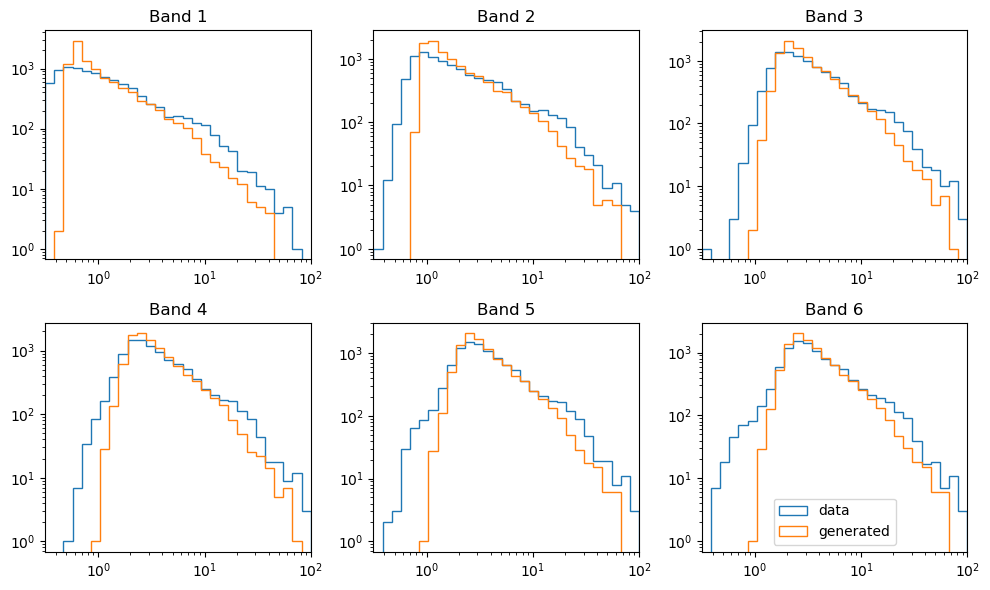

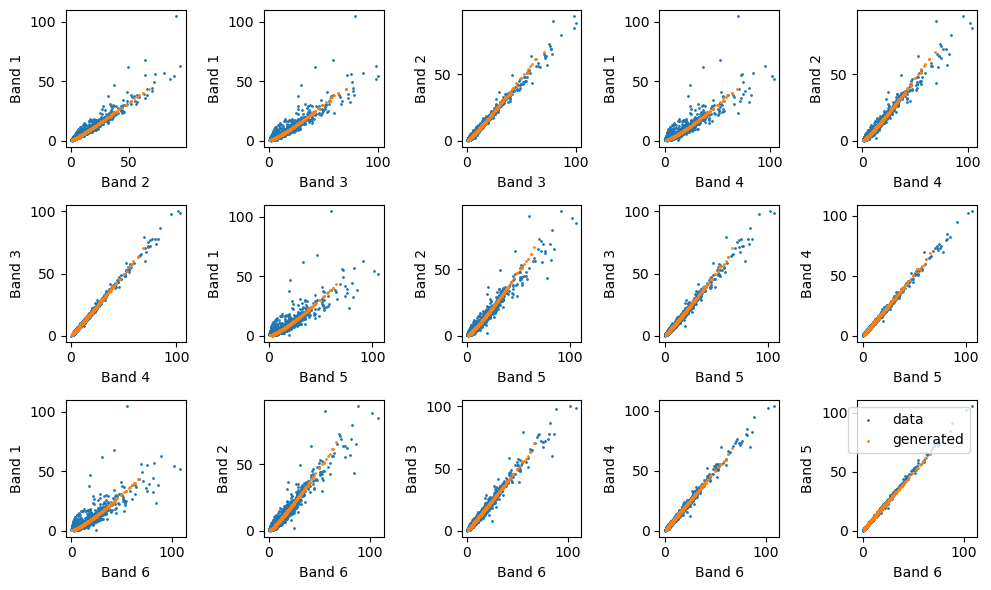

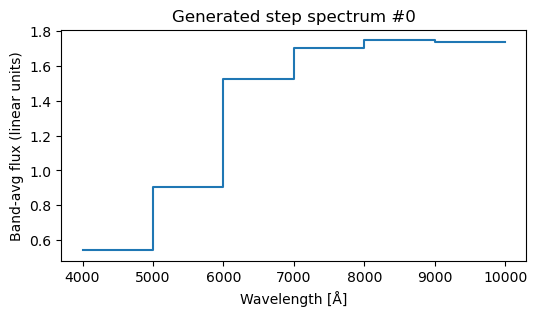

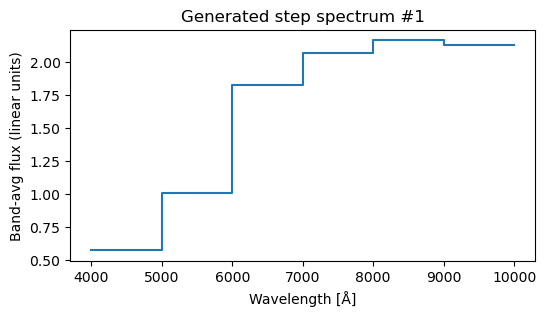

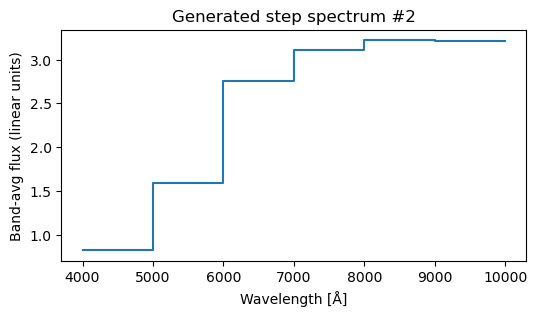

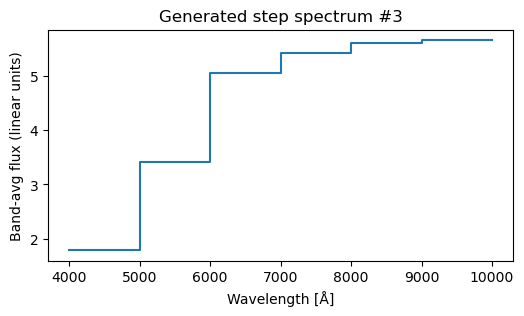

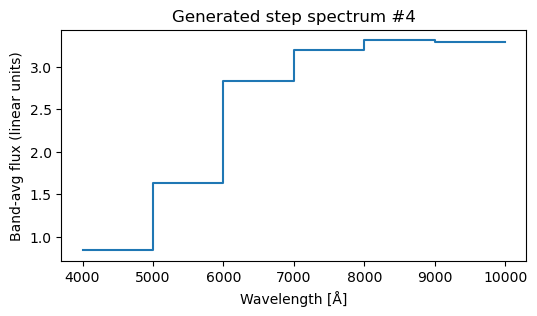

In [53]:
# --- 前提: VAEクラス + 学習済み model, そして stats = {"mu":..., "std":...} がある ---
import torch
import numpy as np
import matplotlib.pyplot as plt

def sample_vae(model, n=32, device="cpu"):
    model.eval()
    with torch.no_grad():
        z_dim = model.mu.out_features
        z = torch.randn(n, z_dim, device=device)
        x_hat = model.decode(z)  # 標準化空間の再構成（学習時に標準化していれば）
    return x_hat.cpu().numpy()  # (n,6)

def inverse_standardize(x_std, stats):
    # x = x_std * std + mu
    mu = stats["mu"].cpu().numpy() if torch.is_tensor(stats["mu"]) else np.asarray(stats["mu"])
    std = stats["std"].cpu().numpy() if torch.is_tensor(stats["std"]) else np.asarray(stats["std"])
    return x_std * std + mu

# 1) サンプルの数値を見る
x_gen_std = sample_vae(model, n=9905, device=next(model.parameters()).device)
x_gen = inverse_standardize(x_gen_std, stats)  # 物理スケールに戻す
x_gen = 10**x_gen
print("Generated 6D samples (first 5 rows):\n", np.round(x_gen[:5], 4))

# 2) ヒストグラム & 簡易相関（いくつかのペアだけ散布図）
fig = plt.figure(figsize=(10, 6))
xbin = 10**np.linspace(-0.5, 2.0, 30)
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.hist(X[:,i], bins=xbin, histtype="step", label="data")
    plt.hist(x_gen[:, i], bins=xbin, histtype="step", label="generated")
    plt.title(f"Band {i+1}")
    plt.xlim(10**(-0.5), 100)
    plt.xscale("log")
    plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.show()

pairs = [(0,1),(1,2),(2,3)]
fig = plt.figure(figsize=(10, 6))
k = 0
for i in range(6):
    if i >0:
        for j in range(i):
            k += 1
            ax = fig.add_subplot(3, 5, k)
            ax.scatter(X[:,i], X[:,j], s=1, label="data")
            ax.scatter(x_gen[:, i], x_gen[:, j], s=1, label="generated")
            
            ax.set_xlabel(f"Band {i+1}")
            ax.set_ylabel(f"Band {j+1}")
plt.tight_layout()
plt.legend()

# 3) “段々”スペクトルで見る（5本表示）
band_edges = np.array([4000, 5000, 6000, 7000, 8000, 9000, 10000])  # Å
for k in range(min(5, len(x_gen))):
    # ステップ表示のため、各帯の値を繰り返して edges に合わせる
    y = np.repeat(x_gen[k], 2)            # [a,a,b,b,c,c,...,f,f]
    x = np.repeat(band_edges, 1)[1:-1]    # 中点表示でもOKだが、step でエッジに合わせる
    # step 用の形に整える
    xx = np.repeat(band_edges, 2)[1:-1]   # [5000,5000,6000,6000,...,9000,9000]
    yy = np.repeat(x_gen[k], 2)           # 同じ長さに

    plt.figure(figsize=(6,3))
    plt.step(xx, yy, where="post")
    plt.xlabel("Wavelength [Å]")
    plt.ylabel("Band-avg flux (linear units)")
    plt.title(f"Generated step spectrum #{k}")
    plt.show()


In [24]:
len(X[:,0])

9905